In [28]:
import os
import shutil
import numpy as np

# Paths to VOC directories
base_dir = '/Volumes/T7-apps/aml_dataset//VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files from trainval.txt
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)  # Shuffle to randomize the split

split_index = int(len(trainval_files) * 0.9)
train_files = trainval_files[:split_index]
val_files = trainval_files[split_index:]


In [29]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

# Esempio di utilizzo
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Usa la tua lista 'train_files' generata nel tuo codice precedente
train_dataset = RotationDataset(train_files, images_dir, transform=transform_pipeline)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import time
import copy


# --- 1. CONFIGURAZIONE ---
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
PATIENTCE = 3
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando device: {DEVICE}")

# --- 2. DATALOADERS ---
# Creiamo il dataset di validazione (assicurati di aver definito val_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline)

# Creiamo i generatori di batch
# --- 2. DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. DEFINIZIONE DEL MODELLO ---
# Scarichiamo una ResNet18 pre-addestrata
model = models.resnet18(pretrained=True)

# Congeliamo i pesi (facoltativo, ma velocizza se hai pochi dati)
# per un task semplice come la rotazione, spesso conviene NON congelare tutto, 
# ma se vuoi farlo:
# for param in model.parameters():
#     param.requires_grad = False

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 
model = model.to(DEVICE)

# --- 4. LOSS E OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


# --- 5. FUNZIONE DI TRAINING ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=3 ):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Ogni epoca ha una fase di training e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Imposta il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()   # Imposta il modello in modalità valutazione
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Itera sui dati
            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Azzera i gradienti dei parametri
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize solo se in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistiche
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.item() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salva metriche
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

                # --- EARLY STOPPING LOGIC ---
                # Aggiorna lo scheduler
                scheduler.step()

                # Se la loss migliora, salviamo il modello e resettiamo il contatore
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    # print("  -> Miglioramento rilevato, modello salvato.")
                else:
                    epochs_no_improve += 1
                    print(f"  -> Nessun miglioramento per {epochs_no_improve}/{patience} epoche.")

        print() # Rigo vuoto tra epoche

        # Se non miglioriamo per 'patience' epoche, fermiamo tutto
        if epochs_no_improve >= patience:
            print(f"Early Stopping attivato! Nessun miglioramento per {patience} epoche consecutive.")
            break

    time_elapsed = time.time() - start_time
    print(f'Training completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, history

# --- 6. AVVIO DEL TRAINING ---
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, patience=PATIENTCE)

# --- 7. SALVATAGGIO DEL MODELLO ---
torch.save(trained_model.state_dict(), 'fineTuning_resNet18_version2.pth')
print("Modello salvato come fineTuning_resNet18_version2.pth")

Usando device: mps
Epoch 1/30
----------
train Loss: 0.9551 Acc: 0.6074
val Loss: 0.8691 Acc: 0.6239

Epoch 2/30
----------
train Loss: 0.7368 Acc: 0.7060
val Loss: 0.6549 Acc: 0.7478

Epoch 3/30
----------
train Loss: 0.6776 Acc: 0.7392
val Loss: 0.6976 Acc: 0.7470
  -> Nessun miglioramento per 1/3 epoche.

Epoch 4/30
----------
train Loss: 0.6233 Acc: 0.7630
val Loss: 0.6101 Acc: 0.7782

Epoch 5/30
----------
train Loss: 0.5848 Acc: 0.7718
val Loss: 0.5744 Acc: 0.7816

Epoch 6/30
----------
train Loss: 0.5491 Acc: 0.7917
val Loss: 0.4806 Acc: 0.8146

Epoch 7/30
----------
train Loss: 0.5365 Acc: 0.8006
val Loss: 0.5226 Acc: 0.8007
  -> Nessun miglioramento per 1/3 epoche.

Epoch 8/30
----------
train Loss: 0.5087 Acc: 0.8125
val Loss: 0.4617 Acc: 0.8154

Epoch 9/30
----------
train Loss: 0.4863 Acc: 0.8164
val Loss: 0.4706 Acc: 0.8146
  -> Nessun miglioramento per 1/3 epoche.

Epoch 10/30
----------
train Loss: 0.4657 Acc: 0.8226
val Loss: 0.5429 Acc: 0.7929
  -> Nessun miglioramento

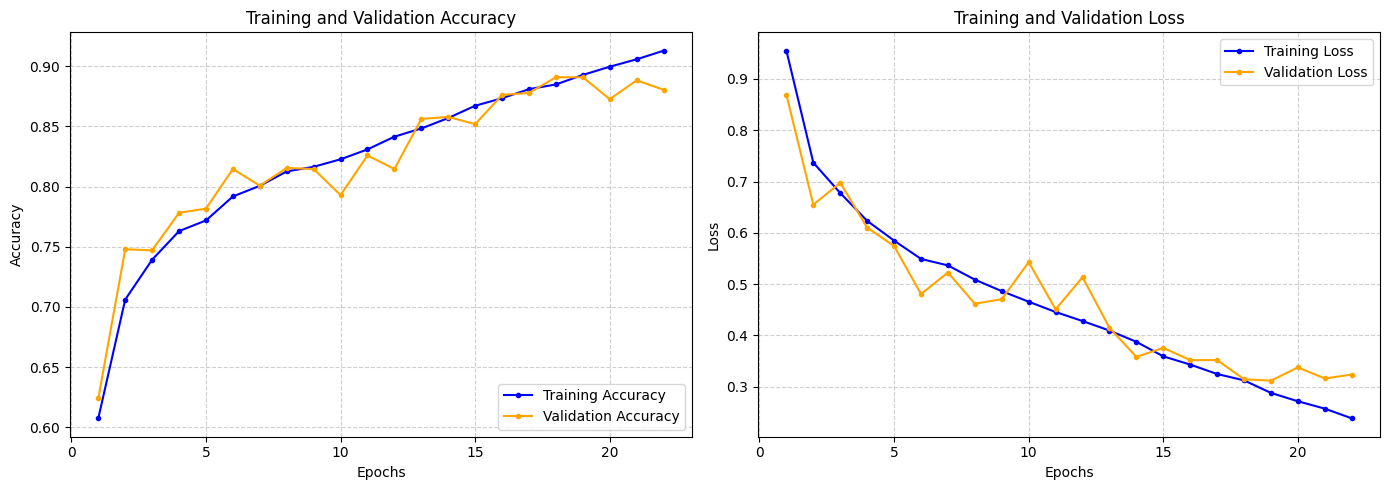

In [31]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Creiamo un array con il numero delle epoche effettive
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # --- GRAFICO 1: ACCURACY ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- GRAFICO 2: LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui la funzione passando la history ottenuta dal training
if 'history' in locals():
    plot_training_results(history)
else:
    print("Errore: Variabile 'history' non trovata. Assicurati che la funzione di training la restituisca.")

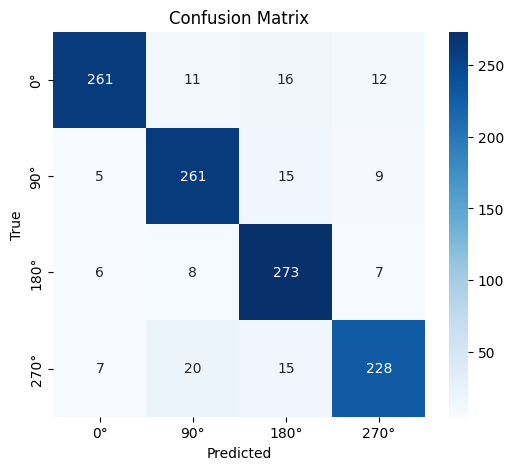

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Run the confusion matrix function
plot_confusion_matrix(model, val_loader, class_names)